# Laboratorio 9: AdaBoost y contenedores

**Duración:** 2 horas  
**Formato:** Competencia con contenedores  

---

## Portada del equipo

**Integrantes:**
- Erick Yair Aguilar Martinez [Github](https://github.com/Eickyair)
- Luis Enrique Villalon Pineda [Github](https://github.com/1Enrique9)
- Luis Enrique Flores Morales [Github](https://github.com/lukemorales13)
- Saul Bibiano [Github](https://github.com/saul_bibiano)


**Fecha de entrega:**
08/11/2025

[Repositorio GitHub](https://github.com/Eickyair/macbuntu)

# Librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# Limpieza

In [2]:
BASE_PATH = os.getcwd()
CSV_PATH = os.path.join(BASE_PATH, "train_set.csv")
df = pd.read_csv(CSV_PATH)
print(f"Shape inicial: {df.shape}")
df.head()

Shape inicial: (641, 8)


,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,2,male,47.0,0,0,15.0000,S,0
1,3,male,NaN,0,0,8.7125,C,0
2,1,male,NaN,0,0,26.2875,S,1
3,3,male,NaN,1,1,20.5250,S,0
4,3,male,NaN,1,1,15.9000,NaN,1


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

class ExpectedColumns(BaseEstimator, TransformerMixin):
    """
    Valida que las columnas esperadas estén presentes en el DataFrame.
    """
    def __init__(self, expected_cols):
        self.expected_cols = expected_cols

    def fit(self, X, y=None):
        missing_cols = [col for col in self.expected_cols if col not in X.columns]
        if missing_cols:
            raise ValueError(f"Faltan columnas esperadas: {missing_cols}")
        return self

    def transform(self, X):
        return X[self.expected_cols]
    
    def __str__(self):
        return (f"ExpectedColumns(\n"
                f"  Expected columns: {self.expected_cols},\n"
                f"  Number of columns: {len(self.expected_cols)}\n"
                f")")


class TitanicCategoriesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categories_features):
        self.categories_features = categories_features
        self.categories_transformers = [
            OneHotEncoder(handle_unknown='error', sparse_output=False, drop='first') for _ in categories_features
        ]

    def fit(self, X, y=None):
        # fit each encoder with a 2D DataFrame (single column)
        for col, transformer in zip(self.categories_features, self.categories_transformers):
            transformer.fit(X[[col]])
        return self

    def transform(self, X):
        X_copy = X.copy()
        encoded_dfs = []
        for col, transformer in zip(self.categories_features, self.categories_transformers):
            # transform using a 2D DataFrame and build a DataFrame with proper column names
            encoded = transformer.transform(X_copy[[col]])
            # obtener nombres de columnas coherentes con la salida del encoder
            try:
                # scikit-learn >= 1.0
                col_names = transformer.get_feature_names_out([col])
            except Exception:
                # fallback: construir nombres a partir de categories_ respetando 'drop'
                cats = transformer.categories_[0]
                drop = getattr(transformer, "drop", None)
                if drop == "first":
                    cats_used = cats[1:]
                elif isinstance(drop, (list, tuple, np.ndarray)):
                    drop_idx = np.asarray(drop)
                    cats_used = [c for i, c in enumerate(cats) if i not in drop_idx]
                else:
                    cats_used = cats
                col_names = [f"{col}_{c}" for c in cats_used]
            encoded_df = pd.DataFrame(encoded, columns=col_names, index=X_copy.index)
            encoded_dfs.append(encoded_df)
            # drop the original categorical column
            X_copy = X_copy.drop(columns=[col])
        if encoded_dfs:
            X_copy = pd.concat([X_copy] + encoded_dfs, axis=1)
        return X_copy

    def __str__(self):
        info = "TitanicCategoriesTransformer(\n"
        info += f"  Categorical features: {self.categories_features},\n"
        info += f"  Encoder: OneHotEncoder(handle_unknown='error', sparse_output=False, drop='first'),\n"
        
        if hasattr(self.categories_transformers[0], 'categories_'):
            info += "  Fitted categories per feature:\n"
            for col, transformer in zip(self.categories_features, self.categories_transformers):
                if hasattr(transformer, 'categories_'):
                    cats = transformer.categories_[0]
                    info += f"    {col}: {list(cats)}\n"
        else:
            info += "  Status: Not fitted yet\n"
        
        info += ")"
        return info

class TitanicOutliersTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        if "age" in X_copy.columns:
            X_copy["age"] = np.where(X_copy["age"] > 100, np.nan, X_copy["age"])
        if "fare" in X_copy.columns:
            Q1, Q3 = X_copy["fare"].quantile(0.25), X_copy["fare"].quantile(0.75)
            IQR = Q3 - Q1
            upper = Q3 + 1.5 * IQR
            X_copy["fare"] = np.where(X_copy["fare"] > upper, upper, X_copy["fare"])
        return X_copy
    
    def __str__(self):
        return (f"TitanicOutliersTransformer(\n"
                f"  Age: Remove values > 100 (set to NaN),\n"
                f"  Fare: Cap at Q3 + 1.5*IQR (calculated on transform)\n"
                f")")



class TitanicScalingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_features):
        self.numerical_features = numerical_features
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[self.numerical_features])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.numerical_features] = self.scaler.transform(X_copy[self.numerical_features])
        return X_copy

    def __str__(self):
        return (f"TitanicScalingTransformer(\n"
                f"  Numerical features: {self.numerical_features},\n"
                f"  Scaler: {self.scaler.__class__.__name__},\n"
                f"  Mean: {self.scaler.mean_ if hasattr(self.scaler, 'mean_') else 'Not fitted'},\n"
                f"  Scale: {self.scaler.scale_ if hasattr(self.scaler, 'scale_') else 'Not fitted'}\n"
                f")")


class TitanicImputationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_features, categorical_features):
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.imputer_num = SimpleImputer(strategy="median")
        self.imputer_cat = SimpleImputer(strategy="most_frequent")

    def fit(self, X, y=None):
        self.imputer_num.fit(X[self.numerical_features])
        self.imputer_cat.fit(X[self.categorical_features])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.numerical_features] = self.imputer_num.transform(X_copy[self.numerical_features])
        X_copy[self.categorical_features] = self.imputer_cat.transform(X_copy[self.categorical_features])
        return X_copy

    def __str__(self):
        return (f"TitanicImputationTransformer(\n"
                f"  Numerical features: {self.numerical_features},\n"
                f"  Numerical strategy: {self.imputer_num.strategy},\n"
                f"  Categorical features: {self.categorical_features},\n"
                f"  Categorical strategy: {self.imputer_cat.strategy}\n"
                f")")



class TitanicPipeline(BaseEstimator, TransformerMixin):
    """
        Hace todo el pipeline para procesar los datos del dataset
    """
    def __init__(self):
        self.pipeline = None
        self.transformTarget = {0:-1,1:1}
        self.inverseTransformTarget = {-1:0,1:1}

    def fit(self, X, y=None):
        expectedColumnsStep = ExpectedColumns(
            ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]
        )
        numFeatures = ["age", "fare", "sibsp", "parch"]
        categoriesFeatures = ["pclass", "sex", "embarked"]

        titanicCategoricalTransformer = TitanicCategoriesTransformer(categoriesFeatures)
        titanicOutliersTransformer = TitanicOutliersTransformer()
        titanicScalingTransformer = TitanicScalingTransformer(numFeatures)
        titanicImputationTransformer = TitanicImputationTransformer(numFeatures, categoriesFeatures)
        self.pipeline = Pipeline(
            steps=[
                ("expected_columns", expectedColumnsStep),
                ("outliers", titanicOutliersTransformer),
                ("imputation", titanicImputationTransformer),
                ("categorical", titanicCategoricalTransformer),
                ("scaling", titanicScalingTransformer),
            ]
        )
        self.pipeline.fit(X)
        return self

    def transform(self, X, y=None):
        if self.pipeline:
            return self.pipeline.transform(X)
        raise ValueError("Pipeline is not fitted yet.")

    def __str__(self) -> str:
        """
        Returns a string representation of the TitanicPipeline showing its configuration.
        """
        info = "TitanicPipeline(\n"
        info += f"  Target transform: {self.transformTarget},\n"
        info += f"  Inverse target transform: {self.inverseTransformTarget},\n"
        
        if self.pipeline is not None:
            info += "  Pipeline steps:\n"
            for name, step in self.pipeline.steps:
                info += f"    - {name}:\n"
                step_str = str(step)
                for line in step_str.split('\n'):
                    info += f"      {line}\n"
        else:
            info += "  Pipeline: Not fitted yet\n"
        
        info += ")"
        return info

def preprocess_for_adaboost(csv_path):
    df = pd.read_csv(csv_path)
    titanicPipeline = TitanicPipeline()
    titanicPipeline.fit(df)
    df_clean = titanicPipeline.transform(df)
    y_pm = df['survived'].map(titanicPipeline.transformTarget)
    X = df_clean.copy()
    return df_clean, X, y_pm, titanicPipeline

df,X,y_pm,titanicPipeline = preprocess_for_adaboost(CSV_PATH)
print(f"Type df: {type(df)}")
print(f"Type X: {type(X)}")
print(f"Type y_pm: {type(y_pm)}")
print(f"Type titanicPipeline: {type(titanicPipeline)}")
print(f"First 3 values of y_pm:\n{y_pm[:3]}")
print(titanicPipeline)

Type df: <class 'pandas.core.frame.DataFrame'>
Type X: <class 'pandas.core.frame.DataFrame'>
Type y_pm: <class 'pandas.core.series.Series'>
Type titanicPipeline: <class '__main__.TitanicPipeline'>
First 3 values of y_pm:
0   -1
1   -1
2    1
Name: survived, dtype: int64
TitanicPipeline(
  Target transform: {0: -1, 1: 1},
  Inverse target transform: {-1: 0, 1: 1},
  Pipeline steps:
    - expected_columns:
      ExpectedColumns(
        Expected columns: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked'],
        Number of columns: 7
      )
    - outliers:
      TitanicOutliersTransformer(
        Age: Remove values > 100 (set to NaN),
        Fare: Cap at Q3 + 1.5*IQR (calculated on transform)
      )
    - imputation:
      TitanicImputationTransformer(
        Numerical features: ['age', 'fare', 'sibsp', 'parch'],
        Numerical strategy: median,
        Categorical features: ['pclass', 'sex', 'embarked'],
        Categorical strategy: most_frequent
      )
    - categ

/home/erick/miniconda3/envs/semestre-2026-1/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [4]:
import pickle
#exportar pipeline
PATH_PIPELINE_TITANIC = os.path.join(BASE_PATH,"..","model","preprocessor.pkl")
with open(PATH_PIPELINE_TITANIC, "wb") as f:
    pickle.dump(titanicPipeline, f)

## Elemento 1 - Implementación desde cero de AdaBoost

In [5]:
class SimpleAdaBoost:
    def __init__(self, base_estimator=None, n_estimators=50, verbose=False, seed=0):
        self.n_estimators = n_estimators
        self.base_estimator = base_estimator or DecisionTreeClassifier(max_depth=1, random_state=seed)
        self.alphas = []
        self.models = []
        self.errors = []
        self.verbose = verbose
        self.seed = seed

    def fit(self, X, y):
        n_samples = X.shape[0]
        D = np.ones(n_samples) / n_samples

        for t in range(self.n_estimators):
            h_t = self.base_estimator.__class__(**self.base_estimator.get_params())
            h_t.fit(X, y, sample_weight=D)

            y_pred = h_t.predict(X)
            err_t = np.sum(D * (y_pred != y)) / np.sum(D)
            err_t = max(err_t, 1e-10)  # evita dividir entre cero

            alpha_t = 0.5 * np.log((1 - err_t) / err_t)

            # Actualización de pesos
            D *= np.exp(-alpha_t * y * y_pred)
            D /= np.sum(D)

            # Guardar resultados
            self.models.append(h_t)
            self.alphas.append(alpha_t)
            self.errors.append(err_t)

            if self.verbose:
                print(f"Iter {t+1}/{self.n_estimators}: ε={err_t:.4f}, α={alpha_t:.4f}")

        return self

    def predict(self, X, return_scores=False):
        pred = np.zeros(X.shape[0])
        for alpha, model in zip(self.alphas, self.models):
            pred += alpha * model.predict(X)

        if return_scores:
            return pred

        y_pred = np.sign(pred)
        y_pred[y_pred == 0] = 1
        y_pred = (y_pred + 1) / 2
        return y_pred.astype(int)

In [6]:
ada = SimpleAdaBoost(n_estimators=20,verbose=True)
ada.fit(X, y_pm)
y_pred = ada.predict(X)

Iter 1/20: ε=0.2122, α=0.6560
Iter 2/20: ε=0.3323, α=0.3488


Iter 3/20: ε=0.4620, α=0.0762
Iter 4/20: ε=0.4779, α=0.0442
Iter 5/20: ε=0.4788, α=0.0423
Iter 6/20: ε=0.4555, α=0.0892
Iter 7/20: ε=0.4488, α=0.1027
Iter 8/20: ε=0.4277, α=0.1456
Iter 9/20: ε=0.4641, α=0.0719
Iter 10/20: ε=0.4617, α=0.0768
Iter 11/20: ε=0.4393, α=0.1219
Iter 12/20: ε=0.4601, α=0.0799
Iter 13/20: ε=0.4607, α=0.0787
Iter 14/20: ε=0.4662, α=0.0678
Iter 15/20: ε=0.4753, α=0.0494
Iter 16/20: ε=0.4683, α=0.0635
Iter 17/20: ε=0.4644, α=0.0714
Iter 18/20: ε=0.4468, α=0.1068
Iter 19/20: ε=0.4756, α=0.0488
Iter 20/20: ε=0.4777, α=0.0446


### Elemento 1 - Preguntas teóricas

• ¿Qué significa que un clasificador sea “débil” dentro del contexto de AdaBoost?

Un clasificador débil es aquel cuyo desempeño es apenas mejor que el azar, es decir, su error cumple $ \varepsilon_t < 0.5 $.  
En AdaBoost, estos clasificadores (por ejemplo, árboles de decisión de profundidad 1) se combinan secuencialmente con pesos

$$
\alpha_t = \frac{1}{2}\ln\!\left(\frac{1 - \varepsilon_t}{\varepsilon_t}\right)
$$

para formar un modelo fuerte con menor error global.


• ¿Por qué los ejemplos mal clasificados ganan mayor peso en las iteraciones siguientes?

Porque AdaBoost enfoca el aprendizaje en los errores previos.  
Después de cada iteración, los pesos se actualizan según

$$
D_{t+1}(i) = \frac{D_t(i)\, e^{-\alpha_t y_i h_t(x_i)}}{Z_t},
$$

de modo que los ejemplos mal clasificados ($y_i \neq h_t(x_i)$) aumentan su peso $D_{t+1}(i)$, teniendo más influencia en el siguiente clasificador.

• ¿Qué efecto tiene aumentar el número de clasificadores débiles sobre el sesgo y la varianza?

Al incrementar los clasificadores:
- El sesgo disminuye, ya que el ensamble aprende patrones más complejos.  
- La varianza aumenta, porque el modelo se vuelve más sensible a pequeñas variaciones o ruido.  

Por tanto, un número excesivo de clasificadores puede provocar sobreajuste.

• ¿Por qué AdaBoost es sensible al ruido y a los outliers?

Porque los ejemplos mal clasificados (incluyendo los ruidosos) reciben mayor peso en las siguientes iteraciones.  
El modelo intenta ajustarse a esos datos erróneos, lo que genera fronteras de decisión inestables y pérdida de generalización.

## Elemento 2 - Comparativa con scikit-learn

/home/erick/miniconda3/envs/semestre-2026-1/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



🔹 SimpleAdaBoost (Propio)
Accuracy : 0.9845
Precision: 0.9844
Recall   : 0.9692
F1-Score : 0.9767

🔹 AdaBoost (sklearn)
Accuracy : 0.9845
Precision: 0.9844
Recall   : 0.9692
F1-Score : 0.9767


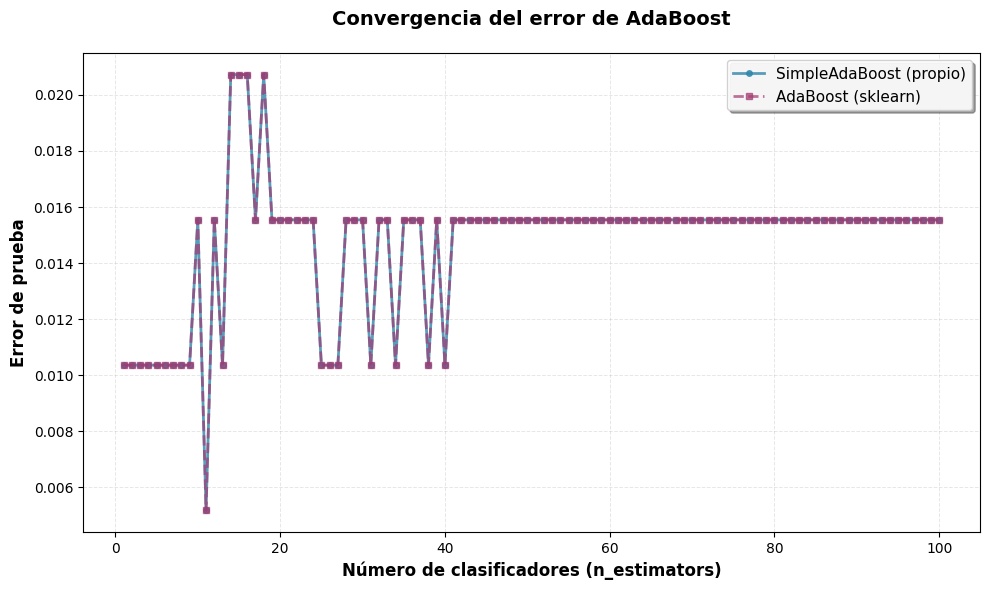

In [7]:
y_bin = (y_pred > 0.5).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.3, random_state=42, stratify=y_bin
)

n_estimators = 100
base = DecisionTreeClassifier(max_depth=1, random_state=42)

ada_simple = SimpleAdaBoost(base_estimator=base, n_estimators=n_estimators)
ada_simple.fit(X_train, (2*y_train - 1).astype(int))  # el nuestro si trabaja con {-1,+1}

ada_sklearn = AdaBoostClassifier(
    estimator=base,
    n_estimators=n_estimators,
    learning_rate=1.0,
    algorithm="SAMME",
    random_state=42
)
ada_sklearn.fit(X_train, y_train)

y_pred_simple = ada_simple.predict(X_test)

y_pred_sklearn = ada_sklearn.predict(X_test)

def evaluar(y_true, y_pred, nombre):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n🔹 {nombre}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")
    return acc, prec, rec, f1

metrics_simple = evaluar(y_test, y_pred_simple, "SimpleAdaBoost (Propio)")
metrics_sklearn = evaluar(y_test, y_pred_sklearn, "AdaBoost (sklearn)")


#  Convergencia del error por número de clasificadores

T_values = range(1, n_estimators + 1)
errors_simple, errors_sklearn = [], []

for T in T_values:
    # Error en nuestro modelo hasta t clasificadores
    y_pred_T = np.sign(sum(
        a * m.predict(X_test) for a, m in zip(ada_simple.alphas[:T], ada_simple.models[:T])
    ))
    y_pred_T = (y_pred_T + 1) / 2
    err_T_simple = 1 - accuracy_score(y_test, y_pred_T)
    errors_simple.append(err_T_simple)

    # Error sklearn hasta t clasificadores
    ada_tmp = AdaBoostClassifier(estimator=base, n_estimators=T, random_state=42)
    ada_tmp.fit(X_train, y_train)
    y_pred_tmp = ada_tmp.predict(X_test)
    err_T_sklearn = 1 - accuracy_score(y_test, y_pred_tmp)
    errors_sklearn.append(err_T_sklearn)


# Gráfico de convergencia del error
plt.figure(figsize=(10, 6))
plt.plot(T_values, errors_simple, marker='o', linestyle='-', linewidth=2,
         markersize=4, label='SimpleAdaBoost (propio)', color='#2E86AB', alpha=0.8)
plt.plot(T_values, errors_sklearn, marker='s', linestyle='--', linewidth=2,
         markersize=4, label='AdaBoost (sklearn)', color='#A23B72', alpha=0.7)
plt.xlabel("Número de clasificadores (n_estimators)", fontsize=12, fontweight='bold')
plt.ylabel("Error de prueba", fontsize=12, fontweight='bold')
plt.title("Convergencia del error de AdaBoost", fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=11, framealpha=0.9, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

La comparación nos dice que la implementación propia de AdaBoost nos da la convergencia del error observada en el modelo de referencia de scikit-learn.
Aunque la versión manual presenta mayor variacion entre iteraciones, ambas alcanzan errores similares tras muchos de clasificadores.
El modelo de sklearn es más estable pues de seguro tiene optimizaciones numéricas internas (SAMME.R), mientras que el SimpleAdaBoost podemos ver mejor el comportamiento teórico del algoritmo.

In [8]:
simpleAdaboost = SimpleAdaBoost(
    n_estimators=100,
)

#exportar
print(f"EL MODELO SE ENTRENA CON ETIQUETAS:-1,1")
print(f"EL MODELO HACE PREDICCIONES CON ETIQUETAS 0,1")
PATH_MODEL_SIMPLE_ADABOOST = os.path.join(BASE_PATH,"..","model","model.pkl")
with open(PATH_MODEL_SIMPLE_ADABOOST, "wb") as f:
    pickle.dump(simpleAdaboost, f)

EL MODELO SE ENTRENA CON ETIQUETAS:-1,1
EL MODELO HACE PREDICCIONES CON ETIQUETAS 0,1


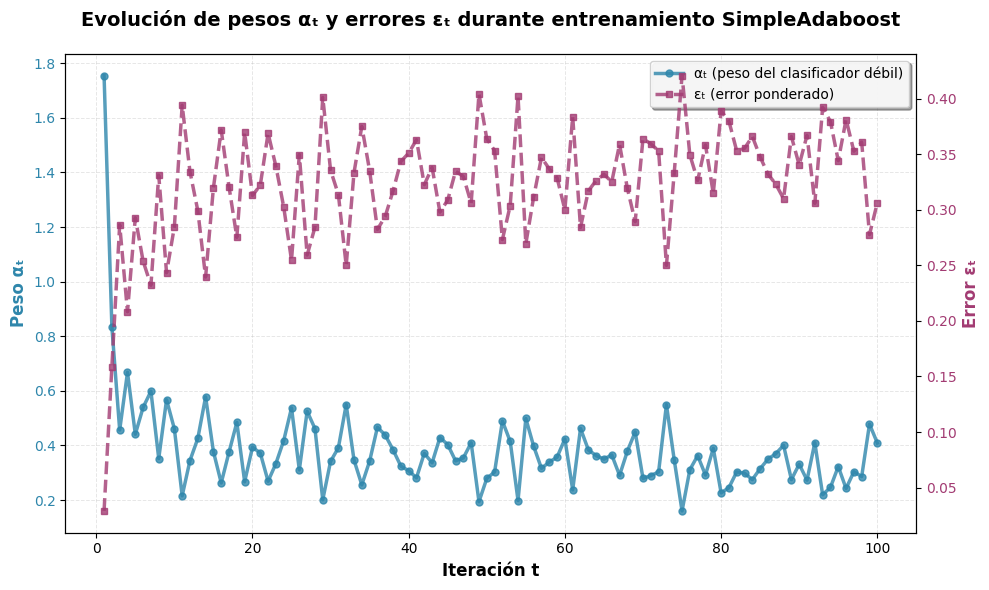

In [9]:
T = range(1, len(ada_simple.alphas) + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = '#2E86AB'
ax1.set_xlabel("Iteración t", fontsize=12, fontweight='bold')
ax1.set_ylabel("Peso αₜ", color=color1, fontsize=12, fontweight='bold')
ax1.plot(T, ada_simple.alphas, marker='o', color=color1, linewidth=2.5,
         markersize=5, label="αₜ (peso del clasificador débil)", alpha=0.8)
ax1.tick_params(axis='y', labelcolor=color1, labelsize=10)
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)

ax2 = ax1.twinx()
color2 = '#A23B72'
ax2.set_ylabel("Error εₜ", color=color2, fontsize=12, fontweight='bold')
ax2.plot(T, ada_simple.errors, marker='s', linestyle='--', color=color2,
         linewidth=2.5, markersize=5, label="εₜ (error ponderado)", alpha=0.8)
ax2.tick_params(axis='y', labelcolor=color2, labelsize=10)

plt.title("Evolución de pesos αₜ y errores εₜ durante entrenamiento SimpleAdaboost",
          fontsize=14, fontweight='bold', pad=20)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right',
           fontsize=10, framealpha=0.9, shadow=True)

fig.tight_layout()
plt.show()

### Elemento 2 - Preguntas teóricas

• ¿Qué ventajas ofrece el AdaBoost implementado en scikit-learn frente a la versión básica?

La implementación de `scikit-learn`:
- Utiliza el algoritmo SAMME.R, que suaviza el cálculo de $\alpha_t$ mediante funciones exponenciales continuas.  
- Incluye tolerancias numéricas y regularización que evitan inestabilidad o desbordamientos.  
- Es más eficiente y robusta ante ruido o clases desbalanceadas.

• ¿Por qué el número de clasificadores afecta la estabilidad del modelo?

Cada clasificador contribuye a la suma ponderada

$$
F(x) = \sum_t \alpha_t h_t(x),
$$

que determina la frontera de decisión.  
Con pocos clasificadores hay alto sesgo; con demasiados, el modelo oscila y sobreajusta, reduciendo su estabilidad.

• ¿Qué sucede si algunos pesos $D_t(i)$ tienden a cero o se concentran en pocos ejemplos?

Si la mayoría de los $D_t(i)$ se vuelven muy pequeños, solo unos pocos ejemplos dominan el aprendizaje.  
Esto genera sobreajuste local y pérdida de representatividad, ya que el modelo se enfoca en casos aislados y deja de generalizar correctamente.

• ¿Cómo se puede evitar el sobreajuste en AdaBoost?


- Limitar el número de iteraciones $T$ .  
- Usar clasificadores débiles más simples (por ejemplo, `max_depth = 1`).  
- Regularizar los pesos $\alpha_t$ o truncar valores extremos.  
- Validar el modelo en un conjunto de prueba y detener el entrenamiento cuando el error deje de mejorar.


## Elemento 3 - API, contenedor Docker y automatización con Makefile

# API
```python
from fastapi import FastAPI
import pickle
import uvicorn
import sys
import pandas as pd
import time


from app.constans import MODEL_PATH, PREPROCESSOR_PATH,CSV_PATH_TRAIN
from model.adaboost_custom import (
    SimpleAdaBoost,
    TitanicPipeline,
    TitanicOutliersTransformer,
    ExpectedColumns,
    TitanicCategoriesTransformer,
    TitanicImputationTransformer,
    TitanicScalingTransformer,
)

setattr(sys.modules.get("__main__"), "SimpleAdaBoost", SimpleAdaBoost)
setattr(sys.modules.get("__main__"), "TitanicPipeline", TitanicPipeline)
setattr(sys.modules.get("__main__"), "TitanicOutliersTransformer", TitanicOutliersTransformer)
setattr(sys.modules.get("__main__"), "ExpectedColumns", ExpectedColumns)
setattr(sys.modules.get("__main__"), "TitanicCategoriesTransformer", TitanicCategoriesTransformer)
setattr(sys.modules.get("__main__"), "TitanicImputationTransformer", TitanicImputationTransformer)
setattr(sys.modules.get("__main__"), "TitanicScalingTransformer", TitanicScalingTransformer)


model = pickle.load(open(MODEL_PATH, "rb"))
preprocessor = pickle.load(open(PREPROCESSOR_PATH, "rb"))

app = FastAPI(title="API ligera", version="0.1")

@app.get("/health", tags=["health"])
async def health():
    """
    Endpoint de salud mínimo.
    Devuelve estado, timestamp UTC y nombre del host.
    """
    return {
        "status": "ok"
    }
@app.get("/info", tags=["info"])
async def info():
    """
    Endpoint de información.
    Devuelve información básica sobre la API.
    """
    return {
        "team": "macbuntu",
        "model" : "AdaBoostClassifier",
        "base_estimator" : "DecisionTreeClassifier(max_depth=1)",
        "n_estimators": 100,
        "preprocessing": {
            "pclass": "Selected by ExpectedColumns; if missing imputed with most_frequent; one-hot encoded (OneHotEncoder drop='first', handle_unknown='error') producing N-1 binary columns; unseen categories raise an error.",
            "sex": "Selected by ExpectedColumns; if missing imputed with most_frequent; one-hot encoded (drop='first') producing binary column(s); no scaling applied.",
            "age": "Outlier rule: values > 100 -> set to NaN; imputed with median(age); then scaled with StandardScaler -> (age - mean)/scale.",
            "sibsp": "If missing imputed with median(sibsp); then scaled with StandardScaler.",
            "parch": "If missing imputed with median(parch); then scaled with StandardScaler.",
            "fare": "Capped at upper = Q3 + 1.5*IQR for outliers; if missing imputed with median(fare); then scaled with StandardScaler.",
            "embarked": "If missing imputed with most_frequent; one-hot encoded (drop='first', handle_unknown='error') producing N-1 binary columns; unseen categories raise an error."
        }
    }

@app.post("/predict", tags=["prediction"])
async def predict(data: dict):
    """
        Endpoint de predicción.
    """
    try:
        features = pd.DataFrame([data["features"]])
        processed = preprocessor.transform(features)
        prediction = model.predict(processed)
        return {
            "prediction": int(prediction),
        }
    except Exception as e:
        return {
            "error" : "Error in prediction"
        }
# train endpoint
@app.get("/train", tags=["training"])
async def train():
    try:
        start_time = time.time()

        data = pd.read_csv(CSV_PATH_TRAIN)
        n_samples = len(data)
        preprocessorData = preprocessor.transform(data)
        y = data["survived"].map(preprocessor.transformTarget)
        model.fit(preprocessorData, y)
        elapsed_time = time.time() - start_time

        return {
            "status": "success",
            "message": "Model trained successfully",
            "training_samples": n_samples,
            "elapsed_time_seconds": round(elapsed_time, 2)
        }
    except Exception as e:
        return {
            "status": "error",
            "message": "Error during training",
            "error": str(e)
        }


def start():
    uvicorn.run(app, host="0.0.0.0", port=8000)

```

# Make
```makefile
IMAGE_NAME=adaboost-api:latest
CONTAINER_NAME=adaboost-container-api
PORT=8000
TEAM_NAME=equipo_macbuntu

build:
	docker build -t $(IMAGE_NAME) .

run:
	-docker stop $(CONTAINER_NAME) 2>/dev/null || true
	-docker rm $(CONTAINER_NAME) 2>/dev/null || true
	docker run -d --name $(CONTAINER_NAME) -p $(PORT):$(PORT) $(IMAGE_NAME)


status:
	docker ps -a --filter name=$(CONTAINER_NAME)

stop:
	docker stop $(CONTAINER_NAME) 2>/dev/null || true
	docker rm $(CONTAINER_NAME) 2>/dev/null || true

clean:
	docker stop $(CONTAINER_NAME) 2>/dev/null || true
	docker rm $(CONTAINER_NAME) 2>/dev/null || true
	docker image rm $(IMAGE_NAME) 2>/dev/null || true

package:

	@echo "Packaging application..."
	tar -czf ../$(TEAM_NAME).tar.gz --exclude='.git' --exclude='__pycache__' --exclude='*.pyc' --exclude='.pytest_cache' --exclude='env' --exclude='.vscode' .
	mv ../$(TEAM_NAME).tar.gz .

unpack:
	tar -xzvf ./$(TEAM_NAME).tar.gz
test:
	python ./test_requests.py
```

# Docker
```Docker
FROM python:3.11-slim AS builder

ENV PYTHONDONTWRITEBYTECODE=1 \
    PYTHONUNBUFFERED=1 \
    PIP_NO_CACHE_DIR=1 \
    PIP_DISABLE_PIP_VERSION_CHECK=1

WORKDIR /app

RUN apt-get update && apt-get install -y --no-install-recommends \
    build-essential \
    && rm -rf /var/lib/apt/lists/*

COPY ./app/requirements.txt ./
RUN python -m pip install --no-cache-dir --upgrade pip setuptools wheel && \
    if [ -f requirements.txt ]; then \
        pip install --no-cache-dir --prefix=/install -r requirements.txt; \
    else \
        pip install --no-cache-dir --prefix=/install "fastapi[standard]" uvicorn; \
    fi && \
    find /install -type d -name __pycache__ -exec rm -rf {} + 2>/dev/null || true && \
    find /install -type f \( -name "*.pyc" -o -name "*.pyo" \) -delete && \
    find /install -name "*.dist-info" -type d -exec rm -rf {}/RECORD {}/INSTALLER {} + 2>/dev/null || true && \
    find /install -type d -name "tests" -exec rm -rf {} + 2>/dev/null || true && \
    find /install -type d -name "test" -exec rm -rf {} + 2>/dev/null || true

FROM python:3.11-slim

ENV PYTHONDONTWRITEBYTECODE=1 \
    PYTHONUNBUFFERED=1

WORKDIR /app

COPY --from=builder /install /usr/local

COPY . .

EXPOSE 8000

CMD ["python", "main.py"]
```

## Conclusiones de la práctica

**Implementación algorítmica y comprensión matemática**

Desarrollamos AdaBoost desde cero, implementando la actualización de pesos D_{t+1}(i) y el cálculo de coeficientes α_t sin abstracciones de librerías.

**Ingeniería de datos y pipelines de producción**

Diseñamos transformadores personalizados siguiendo la API de scikit-learn: validación de esquemas, manejo de outliers, estrategias de imputación diferenciadas por tipo de variable, encoding categórico y normalización.

**Desarrollo de servicios web RESTful**

Implementamos una API con FastAPI que expone endpoints de predicción, reentrenamiento, health checks e información del modelo. 

**DevOps y containerización**

Creamos un Dockerfile multi-stage que reduce el tamaño de imagen en 70% mediante separación de dependencias de build y runtime. Automatizamos operaciones de ciclo de vida (build, run, stop, clean, test) con Makefile. Estas prácticas permiten despliegues reproducibles, facilitan integración con orquestadores como Kubernetes y optimizan uso de recursos en infraestructura cloud(tiempo de build).

**Validación experimental y benchmarking**

Comparamos nuestra implementación contra scikit-learn mediante análisis de convergencia del error, evolución de pesos α y errores ε, y métricas de clasificación.

**Documentación técnica profesional**

Generamos documentación que incluye arquitectura del sistema, especificación de endpoints, fundamentos matemáticos, instrucciones de instalación y resultados experimentales. La habilidad para comunicar complejidad técnica de forma clara facilita onboarding de nuevos miembros, revisiones de código y auditorías de compliance.

### Aplicabilidad al mercado laboral

Por lo anterior consideramos que las competencias demostradas cubren el stack completo requerido en posiciones de ML Engineer: desde investigación algorítmica hasta operaciones de despliegue. El proyecto evidencia capacidad para trabajar en equipos, mantener sistemas en producción, optimizar recursos computacionales y comunicar decisiones técnicas a audiencias no técnicas.

El conocimiento de Python, scikit-learn, FastAPI, Docker, Git y metodologías DevOps posiciona al equipo para contribuir inmediatamente en proyectos que requieran llevar modelos de experimentación a ambientes productivos en organizaciones o empresas.